#Installing Requirements

In [ ]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
# Install the required packages
!pip install numpy pandas pydicom scikit-image imageio pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.8 MB/s eta 0:00:00


In [ ]:
!pip install monai torch torchvision nibabel tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
# Install the required packages
!pip install numpy pandas pydicom scikit-image imageio pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

#DICOM Functions

In [ ]:
from typing import AnyStr, BinaryIO, Dict, List, NamedTuple, Optional, Union
import numpy as np
import pandas as pd
import pydicom as dicom
from skimage.exposure import rescale_intensity
import imageio

def dcmread_image(fp: Union[str, os.PathLike[AnyStr], BinaryIO], view: str, index: Optional[np.uint] = None) -> np.ndarray:
    """Read pixel array from DBT DICOM file."""
    ds = dicom.dcmread(fp)
    ds.decompress(handler_name="pylibjpeg")  # Use pylibjpeg for decompression
    pixel_array = ds.pixel_array
    view_laterality = view[0].upper()
    image_laterality = _get_image_laterality(pixel_array[index or 0])

    if index is not None:
        pixel_array = pixel_array[index]

    if not image_laterality == view_laterality:
        pixel_array = np.flip(pixel_array, axis=(-1, -2))

    window_center = _get_window_center(ds)
    window_width = _get_window_width(ds)
    low = (2 * window_center - window_width) / 2
    high = (2 * window_center + window_width) / 2
    pixel_array = rescale_intensity(pixel_array, in_range=(low, high), out_range="dtype")

    return pixel_array

def read_boxes(boxes_fp: str, filepaths_fp: str) -> pd.DataFrame:
    """Read pandas DataFrame with bounding boxes joined with file paths."""
    df_boxes = pd.read_csv(boxes_fp)
    df_filepaths = pd.read_csv(filepaths_fp)
    primary_key = ("PatientID", "StudyUID", "View")
        if not all([key in df_boxes.columns for key in primary_key]):
        raise AssertionError(f"Not all primary key columns {primary_key} are present in bounding boxes columns {df_boxes.columns}")

    if not all([key in df_filepaths.columns for key in primary_key]):
        raise AssertionError(f"Not all primary key columns {primary_key} are present in file paths columns {df_filepaths.columns}")

    return pd.merge(df_boxes, df_filepaths, on=primary_key)

def draw_box(image: np.ndarray, x: int, y: int, width: int, height: int, color: Optional[Union[int, tuple]] = None, lw=4) -> np.ndarray:
    """Draw bounding box on the image."""
    x = min(max(x, 0), image.shape[1] - 1)
    y = min(max(y, 0), image.shape[0] - 1)

    if color is None:
        color = 255

    if len(image.shape) > 2 and not hasattr(color, "__len__"):
        color = (color,) + (0,) * (image.shape[-1] - 1)

    image[y : y + lw, x : x + width] = color
    image[y + height - lw : y + height, x : x + width] = color
    image[y : y + height, x : x + lw] = color
    image[y : y + height, x + width - lw : x + width] = color

    return image

def evaluate(labels_fp: str, boxes_fp: str, predictions_fp: str) -> Dict[str, float]:
    """Evaluate predictions."""
    df_labels = pd.read_csv(labels_fp)
    df_boxes = pd.read_csv(boxes_fp, dtype={"VolumeSlices": float})
    df_pred = pd.read_csv(predictions_fp, dtype={"Score": float})

    df_labels = df_labels.reset_index().set_index(["StudyUID", "View"]).sort_index()
    df_boxes = df_boxes.reset_index().set_index(["StudyUID", "View"]).sort_index()
    df_pred = df_pred.reset_index().set_index(["StudyUID", "View"]).sort_index()

    df_pred["TP"] = 0
    df_pred["GTID"] = -1

    thresholds = [df_pred["Score"].max() + 1.0]

    for box_pred in df_pred.itertuples():
        if box_pred.Index not in df_boxes.index:
            continue

        df_boxes_view = df_boxes.loc[[box_pred.Index]]
        view_slice_offset = df_boxes.loc[[box_pred.Index], "VolumeSlices"].iloc[0] / 4
        tp_boxes = [b for b in df_boxes_view.itertuples() if _is_tp(box_pred, b, slice_offset=view_slice_offset)]

        if len(tp_boxes) > 1:
            tp_distances = [_distance(box_pred, b) for b in tp_boxes]
            tp_boxes = [tp_boxes[np.argmin(tp_distances)]]

        if len(tp_boxes) > 0:
            tp_i = tp_boxes[0].index
            df_pred.loc[df_pred["index"] == box_pred.index, ("TP", "GTID")] = (1, tp_i)
            thresholds.append(box_pred.Score)

    thresholds.append(df_pred["Score"].min() - 1.0)

    evaluation_fps_all = (2.0,)
    tpr_all = _froc(df_pred=df_pred, thresholds=thresholds, n_volumes=len(df_labels), n_boxes=len(df_boxes), evaluation_fps=evaluation_fps_all)
    result = {f"sensitivity_at_2_fps_all": tpr_all[0]}

    df_pred = df_pred[df_pred.index.isin(df_boxes.index)]
    df_labels = df_labels[df_labels.index.isin(df_boxes.index)]
    evaluation_fps_positive = (1.0, 2.0, 3.0, 4.0)
    tpr_positive = _froc(df_pred=df_pred, thresholds=thresholds, n_volumes=len(df_labels), n_boxes=len(df_boxes), evaluation_fps=evaluation_fps_positive)

    result.update(dict((f"sensitivity_at_{int(x)}_fps_positive", y) for x, y in zip(evaluation_fps_positive, tpr_positive)))
    result.update({"mean_sensitivity_positive": np.mean(tpr_positive)})

    return result

def _froc(df_pred: pd.DataFrame, thresholds: List[float], n_volumes: int, n_boxes: int, evaluation_fps: tuple) -> List[float]:
    """Free-response receiver operating characteristic (FROC) calculation."""
    tpr = []
    fps = []

    for th in sorted(thresholds, reverse=True):
        df_th = df_pred.loc[df_pred["Score"] >= th]
        df_th_unique_tp = df_th.reset_index().drop_duplicates(subset=["StudyUID", "View", "TP", "GTID"])
        n_tps_th = float(sum(df_th_unique_tp["TP"]))
        tpr_th = n_tps_th / n_boxes
        n_fps_th = float(len(df_th[df_th["TP"] == 0]))
        fps_th = n_fps_th / n_volumes
        tpr.append(tpr_th)
        fps.append(fps_th)

        if fps_th > max(evaluation_fps):
            break

    return [np.interp(x, fps, tpr) for x in evaluation_fps]

def _is_tp(box_pred: NamedTuple, box_true: NamedTuple, slice_offset: int, min_dist: int = 100) -> bool:
    """Determine if a prediction is a true positive."""
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z + box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice

    dist = np.linalg.norm((pred_x - true_x, pred_y - true_y))
    dist_threshold = np.sqrt(box_true.Width ** 2 + box_true.Height ** 2) / 2.0
    dist_threshold = max(dist_threshold, min_dist)
    slice_diff = np.abs(pred_z - true_z)

    return dist <= dist_threshold and slice_diff <= slice_offset

def _distance(box_pred: NamedTuple, box_true: NamedTuple) -> float:
    """Calculate the Euclidean distance between predicted and true box centers."""
    pred_y = box_pred.Y + box_pred.Height / 2
    pred_x = box_pred.X + box_pred.Width / 2
    pred_z = box_pred.Z + box_pred.Depth / 2
    true_y = box_true.Y + box_true.Height / 2
    true_x = box_true.X + box_true.Width / 2
    true_z = box_true.Slice

    return np.linalg.norm((pred_x - true_x, pred_y - true_y, pred_z - true_z))

def _get_dicom_laterality(ds: dicom.dataset.FileDataset) -> str:
    """Get laterality from DICOM metadata (unreliable)."""
    return ds[0x5200, 0x9229][0][0x0020, 0x9071][0][0x0020, 0x9072].value

def _get_image_laterality(pixel_array: np.ndarray) -> str:
    """Determine laterality based on image pixel intensity."""
    left_edge = np.sum(pixel_array[:, 0])  # sum of left edge pixels
    right_edge = np.sum(pixel_array[:, -1])  # sum of right edge pixels
    return "R" if left_edge < right_edge else "L"

def _get_window_center(ds: dicom.dataset.FileDataset) -> np.float32:
    """Get window center from DICOM metadata."""
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1050].value)

def _get_window_width(ds: dicom.dataset.FileDataset) -> np.float32:
    """Get window width from DICOM metadata."""
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1051].value)



#Processing DICOM Files

In [ ]:
import os

def process_dicom_files(dicom_files: List[str], boxes_csv_path: str, filepaths_csv_path: str, labels_csv_path: str, predictions_csv_path: str):
    # Read bounding boxes and file paths
    df = read_boxes(boxes_csv_path, filepaths_csv_path)

    for dicom_file_path in dicom_files:
        # Extract the view from the file path or use a default view
        view = 'LCC'  # Example view; adjust as needed

        # Read and process the DICOM file
        image_array = dcmread_image(dicom_file_path, view)

        # Draw a bounding box on the image (example coordinates)
        x, y, width, height = 50, 50, 100, 100  # Replace with actual coordinates if available
        image_with_box = draw_box(image_array, x, y, width, height)

        # Save the image with the bounding box
        output_image_path = os.path.splitext(dicom_file_path)[0] + '_output.png'
        imageio.imwrite(output_image_path, image_with_box)

        # Evaluate predictions
        if labels_csv_path and predictions_csv_path:
            evaluation_results = evaluate(labels_csv_path, boxes_csv_path, predictions_csv_path)
            print(f"Evaluation results for {dicom_file_path}: {evaluation_results}")

# Define file paths
boxes_csv_path = '/content/Breast-Cancer-Screening-DBT/boxes.csv'
filepaths_csv_path = '/content/Breast-Cancer-Screening-DBT/filepaths.csv'
labels_csv_path = '/content/Breast-Cancer-Screening-DBT/labels.csv'
predictions_csv_path = '/content/Breast-Cancer-Screening-DBT/predictions.csv'

# Process the DICOM files
process_dicom_files(dicom_files, boxes_csv_path, filepaths_csv_path, labels_csv_path, predictions_csv_path)


#Unzipping and Combining

In [ ]:
# @title
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the function to combine and extract ZIP files
import zipfile
import os
from typing import List

def combine_and_extract_zip_files(zip_files: List[str], extract_to: str) -> List[str]:
    """
    Extract multiple ZIP files into a single directory.
    Collect all DICOM file paths from the extracted directories.

    Parameters:
    - zip_files: List of ZIP file paths to be extracted.
    - extract_to: Directory where the ZIP files will be extracted.

    Returns:
    - List of all DICOM file paths.
    """
    all_dicom_files = []

    # Extract each ZIP file
    for zip_file in zip_files:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

    # Collect all DICOM files from the extracted directories
    for subdir, _, files in os.walk(extract_to):
        for file in files:
            if file.lower().endswith('.dcm'):
                all_dicom_files.append(os.path.join(subdir, file))

    return all_dicom_files


# Define the directory to extract the ZIP files to
extract_to = '/content/dataset/'

# List of ZIP file paths on Google Drive
zip_file_paths = [
    '/content/drive/MyDrive/Praktikum/Breast-Cancer-Screening-DBT_before4000.zip',
    '/content/drive/MyDrive/Praktikum/Breast-Cancer-Screening-DBT.zip'
]

# Combine and extract the ZIP files, and collect all DICOM file paths
dicom_files = combine_and_extract_zip_files(zip_file_paths, extract_to)

# Print the number of DICOM files found
print(f"Found {len(dicom_files)} DICOM files.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 200 DICOM files.


#3D Patching

In [ ]:
import os
import pydicom
import numpy as np
import pandas as pd
from skimage.exposure import rescale_intensity
import nibabel as nib
from tqdm import tqdm
import gc
from typing import List
import random

def load_dicom_volume(dicom_file):
    ds = pydicom.dcmread(dicom_file)
    volume = ds.pixel_array
    volume = rescale_intensity(volume, out_range=(0, 255)).astype(np.uint8)
    return volume

def get_patient_and_study_id(dicom_file_path):
    """
    Extract Patient ID and Study ID from a DICOM file.

    Parameters:
    - dicom_file_path: Path to the DICOM file.

    Returns:
    - patient_id: The Patient ID extracted from the DICOM file.
    - study_uid: The Study ID extracted from the DICOM file.
    """
    ds = pydicom.dcmread(dicom_file_path)
    patient_id = ds.PatientID
    study_uid = ds.StudyInstanceUID
    view = ds.ViewPosition
    return patient_id, study_uid, view

def collect_dicom_files(root_dir: str) -> List[str]:
    """Collect all DICOM file paths from the directory structure."""
    dicom_files = []
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith('.dcm'):
                dicom_files.append(os.path.join(subdir, file))
    return dicom_files

def save_slices_based_on_csv(csv_path, dicom_files, save_dir):
    # Load the CSV file
    csv_data = pd.read_csv(csv_path)

    # Create a DataFrame to save metadata
    df = pd.DataFrame(columns=['PatientID', 'StudyUID', 'view', 'img_path', 'Normal', 'Actionable', 'Benign', 'Cancer'])

    os.makedirs(save_dir, exist_ok=True)

    for dicom_file in tqdm(dicom_files):
        try:
            patient_id, study_uid = get_patient_and_study_id(dicom_file)
            matching_rows = csv_data[(csv_data['PatientID'] == patient_id)]

            if not matching_rows.empty:
                volume = load_dicom_volume(dicom_file)

                for _, row in matching_rows.iterrows():
                    view = row['View']
                    x = row['X']
                    y = row['Y']
                    width = row['Width']
                    height = row['Height']
                    slice_idx = row['Slice']

                    # Ensure the slice index is within bounds
                    if 0 <= slice_idx < volume.shape[0]:
                      try:
                        slice_volume = volume[slice_idx-10:slice_idx+10,y-height-128:y+height+128 ,x-width-128:x+width+128]
                        slice_name = f"{patient_id}_{study_uid}_{view}_slice_{slice_idx}.nii.gz"
                        slice_nifti = nib.Nifti1Image(slice_volume, np.eye(4))
                        nib.save(slice_nifti, os.path.join(save_dir, slice_name))

                        df.loc[len(df)] = [
                            patient_id, study_uid, view, os.path.join(save_dir, slice_name),
                            row['Normal'], row['Actionable'], row['Benign'], row['Cancer']
                        ]
                      except Exception as a:
                        print(print(f"Error getting volume {dicom_file}: {a}"))
        except Exception as e:
            print(f"Error processing {dicom_file}: {e}")
        gc.collect()

    # Save the metadata DataFrame
    df.to_csv(os.path.join(save_dir, 'slices_metadata.csv'), index=False)

# Define paths
csv_path = '/content/drive/MyDrive/Praktikum/boxes.csv'
dicom_dir = '/content/dataset/Breast-Cancer-Screening-DBT/normal/'
save_dir = '/content/3d_slices_nii_3D_30P_normal/'

# Collect all DICOM file paths
dicom_files = collect_dicom_files(dicom_dir)
print(f"Found {len(dicom_files)} DICOM files.")
print(dicom_files[0])

# Process the DICOM files based on the CSV data
save_slices_based_on_csv(csv_path, dicom_files, save_dir)

# Copy the saved slices to Google Drive
!cp -r /content/3d_slices_nii_3D_30P_normal/ /content/drive/MyDrive/Praktikum/3d_dataset_slices_fcsv2_30P_normal/


Found 164 DICOM files.
/content/dataset/Breast-Cancer-Screening-DBT/normal/DBT-P00149/01-01-2000-DBT-S02770-MAMMO screening digital bilateral-29294/11753.000000-NA-97529/1-1.dcm


 79%|███████▉  | 130/164 [00:35<00:10,  3.11it/s]

#3D Patcing-Normal DS

In [ ]:
import os
import pydicom
import numpy as np
import pandas as pd
from skimage.exposure import rescale_intensity
import nibabel as nib
from tqdm import tqdm
import gc
from typing import List
import random

def load_dicom_volume(dicom_file):
    ds = pydicom.dcmread(dicom_file)
    volume = ds.pixel_array
    volume = rescale_intensity(volume, out_range=(0, 255)).astype(np.uint8)
    return volume

def get_patient_and_study_id(dicom_file_path):
    """
    Extract Patient ID and Study ID from a DICOM file.

    Parameters:
    - dicom_file_path: Path to the DICOM file.

    Returns:
    - patient_id: The Patient ID extracted from the DICOM file.
    - study_uid: The Study ID extracted from the DICOM file.
    """
    ds = pydicom.dcmread(dicom_file_path)
    patient_id = ds.PatientID
    study_uid = ds.StudyInstanceUID
    view = ds.ViewPosition
    return patient_id, study_uid, view

def collect_dicom_files(root_dir: str) -> List[str]:
    """Collect all DICOM file paths from the directory structure."""
    dicom_files = []
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith('.dcm'):
                dicom_files.append(os.path.join(subdir, file))
    return dicom_files

def save_slices_based_on_csv(csv_path, dicom_files, save_dir):
    # Load the CSV file
    csv_data = pd.read_csv(csv_path)

    # Create a DataFrame to save metadata
    df = pd.DataFrame(columns=['PatientID', 'StudyUID', 'view', 'img_path', 'Normal', 'Actionable', 'Benign', 'Cancer'])

    os.makedirs(save_dir, exist_ok=True)

    for dicom_file in tqdm(dicom_files):
          patient_id, study_uid, view = get_patient_and_study_id(dicom_file)
          volume = load_dicom_volume(dicom_file)
          #view = row['View']
          # Middle of the image for X and Y
          y = int(volume.shape[1] / 2)
          x = int(volume.shape[2] / 2)
          print(f"Shape X,Y: {y},{x}")
          width = random.randint(200, 250)
          height = random.randint(200, 250)
          slice_idx = random.randint(15, 35)

          # Ensure the slice index is within bounds
          if 0 <= slice_idx-15 < volume.shape[0]:
            slice_volume = volume[slice_idx-10:slice_idx+10,y-height:y+height ,x-width:x+width]
            slice_name = f"{patient_id}_{study_uid}_{view}_slice_{slice_idx}.nii.gz"
            slice_nifti = nib.Nifti1Image(slice_volume, np.eye(4))
            nib.save(slice_nifti, os.path.join(save_dir, slice_name))

# Define paths
csv_path = '/content/drive/MyDrive/Praktikum/boxes.csv'
dicom_dir = '/content/dataset/Breast-Cancer-Screening-DBT/normal/'
save_dir = '/content/3d_slices_nii_3D_20P_normal/'

# Collect all DICOM file paths
dicom_files = collect_dicom_files(dicom_dir)
print(f"Found {len(dicom_files)} DICOM files.")
print(dicom_files[0])

# Process the DICOM files based on the CSV data
save_slices_based_on_csv(csv_path, dicom_files, save_dir)

# Copy the saved slices to Google Drive
!cp -r /content/3d_slices_nii_3D_20P_normal/ /content/drive/MyDrive/Praktikum/3d_dataset_slices_fcsv2_20P_normal/


Found 164 DICOM files.
/content/dataset/Breast-Cancer-Screening-DBT/normal/DBT-P00149/01-01-2000-DBT-S02770-MAMMO screening digital bilateral-29294/11753.000000-NA-97529/1-1.dcm


  0%|          | 0/164 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
  1%|          | 1/164 [00:44<2:01:07, 44.59s/it]

Shape X,Y: 1228,945


  1%|          | 2/164 [01:25<1:54:40, 42.47s/it]

Shape X,Y: 1228,945


  2%|▏         | 3/164 [02:01<1:45:48, 39.43s/it]

Shape X,Y: 1228,945


  2%|▏         | 4/164 [02:36<1:40:15, 37.60s/it]

Shape X,Y: 1228,945


  3%|▎         | 5/164 [03:06<1:32:41, 34.98s/it]

Shape X,Y: 1228,945


  4%|▎         | 6/164 [03:33<1:25:03, 32.30s/it]

Shape X,Y: 1228,945


  4%|▍         | 7/164 [04:05<1:24:21, 32.24s/it]

Shape X,Y: 1228,945


  5%|▍         | 8/164 [04:31<1:18:38, 30.25s/it]

Shape X,Y: 1228,945


  5%|▌         | 9/164 [04:50<1:08:34, 26.55s/it]

Shape X,Y: 1228,945


  6%|▌         | 10/164 [05:08<1:01:48, 24.08s/it]

Shape X,Y: 1228,945


  7%|▋         | 11/164 [05:32<1:00:50, 23.86s/it]

Shape X,Y: 1228,945


  7%|▋         | 12/164 [05:56<1:01:16, 24.19s/it]

Shape X,Y: 1228,945


  8%|▊         | 13/164 [06:14<55:26, 22.03s/it]  

Shape X,Y: 1228,945


  9%|▊         | 14/164 [06:40<58:05, 23.23s/it]

Shape X,Y: 1228,945


  9%|▉         | 15/164 [06:57<53:00, 21.34s/it]

Shape X,Y: 1228,945


 10%|▉         | 16/164 [07:22<55:40, 22.57s/it]

Shape X,Y: 1228,945


 10%|█         | 17/164 [07:53<1:01:48, 25.23s/it]

Shape X,Y: 1228,998


 11%|█         | 18/164 [08:34<1:12:55, 29.97s/it]

Shape X,Y: 1228,998


 12%|█▏        | 19/164 [09:09<1:15:31, 31.25s/it]

Shape X,Y: 1228,998


 12%|█▏        | 20/164 [09:47<1:20:23, 33.50s/it]

Shape X,Y: 1228,998


 13%|█▎        | 21/164 [10:25<1:22:38, 34.68s/it]

Shape X,Y: 1228,998


 13%|█▎        | 22/164 [11:01<1:23:21, 35.22s/it]

Shape X,Y: 1228,998


 14%|█▍        | 23/164 [11:52<1:33:34, 39.82s/it]

Shape X,Y: 1228,998


 15%|█▍        | 24/164 [12:27<1:30:00, 38.57s/it]

Shape X,Y: 1228,998


 15%|█▌        | 25/164 [12:45<1:14:52, 32.32s/it]

Shape X,Y: 1228,945


 16%|█▌        | 26/164 [12:59<1:01:38, 26.80s/it]

Shape X,Y: 1228,945


 16%|█▋        | 27/164 [13:13<52:26, 22.97s/it]  

Shape X,Y: 1228,945


 17%|█▋        | 28/164 [13:30<48:00, 21.18s/it]

Shape X,Y: 1228,945


 18%|█▊        | 29/164 [14:20<1:06:51, 29.71s/it]

Shape X,Y: 1228,998


 18%|█▊        | 30/164 [15:15<1:23:41, 37.47s/it]

Shape X,Y: 1228,998


 19%|█▉        | 31/164 [16:02<1:29:26, 40.35s/it]

Shape X,Y: 1228,998


 20%|█▉        | 32/164 [17:03<1:42:17, 46.50s/it]

Shape X,Y: 1228,998


 20%|██        | 33/164 [17:39<1:34:40, 43.36s/it]

Shape X,Y: 1228,945


 21%|██        | 34/164 [18:17<1:30:26, 41.74s/it]

Shape X,Y: 1228,945


 21%|██▏       | 35/164 [18:53<1:25:41, 39.86s/it]

Shape X,Y: 1228,945


 22%|██▏       | 36/164 [19:26<1:20:58, 37.96s/it]

Shape X,Y: 1228,945


 23%|██▎       | 37/164 [20:04<1:20:28, 38.02s/it]

Shape X,Y: 1228,998


 23%|██▎       | 38/164 [20:37<1:16:42, 36.53s/it]

Shape X,Y: 1228,998


 24%|██▍       | 39/164 [21:16<1:17:24, 37.15s/it]

Shape X,Y: 1228,998


 24%|██▍       | 40/164 [21:48<1:13:18, 35.48s/it]

Shape X,Y: 1228,998


 25%|██▌       | 41/164 [22:47<1:27:26, 42.66s/it]

Shape X,Y: 1228,998


 26%|██▌       | 42/164 [23:30<1:26:46, 42.67s/it]

Shape X,Y: 1228,998


 26%|██▌       | 43/164 [24:06<1:22:09, 40.74s/it]

Shape X,Y: 1228,998


 27%|██▋       | 44/164 [24:57<1:27:39, 43.83s/it]

Shape X,Y: 1228,998


 27%|██▋       | 45/164 [25:42<1:27:39, 44.19s/it]

Shape X,Y: 1228,998


 28%|██▊       | 46/164 [26:24<1:25:21, 43.40s/it]

Shape X,Y: 1228,998


 29%|██▊       | 47/164 [26:55<1:17:39, 39.82s/it]

Shape X,Y: 1228,998


 29%|██▉       | 48/164 [27:24<1:10:29, 36.46s/it]

Shape X,Y: 1228,998


 30%|██▉       | 49/164 [27:38<57:05, 29.79s/it]  

Shape X,Y: 1228,945


 30%|███       | 50/164 [27:52<47:26, 24.97s/it]

Shape X,Y: 1228,945


 31%|███       | 51/164 [28:06<40:46, 21.65s/it]

Shape X,Y: 1228,945


 32%|███▏      | 52/164 [28:20<36:23, 19.50s/it]

Shape X,Y: 1228,945


 32%|███▏      | 53/164 [28:38<35:11, 19.02s/it]

Shape X,Y: 1228,945


 33%|███▎      | 54/164 [28:58<35:17, 19.25s/it]

Shape X,Y: 1228,945


 34%|███▎      | 55/164 [29:19<35:55, 19.77s/it]

Shape X,Y: 1228,945


 34%|███▍      | 56/164 [29:36<34:28, 19.15s/it]

Shape X,Y: 1228,945


 35%|███▍      | 57/164 [30:00<36:15, 20.33s/it]

Shape X,Y: 1228,945


 35%|███▌      | 58/164 [30:17<34:17, 19.41s/it]

Shape X,Y: 1228,945


 36%|███▌      | 59/164 [30:40<36:03, 20.61s/it]

Shape X,Y: 1228,945


 37%|███▋      | 60/164 [30:59<34:55, 20.15s/it]

Shape X,Y: 1228,945


 37%|███▋      | 61/164 [31:29<39:34, 23.06s/it]

Shape X,Y: 1228,998


 38%|███▊      | 62/164 [31:57<41:43, 24.55s/it]

Shape X,Y: 1228,998


 38%|███▊      | 63/164 [32:27<43:50, 26.04s/it]

Shape X,Y: 1228,998


 39%|███▉      | 64/164 [33:10<52:01, 31.21s/it]

Shape X,Y: 1228,998


 40%|███▉      | 65/164 [33:54<57:38, 34.94s/it]

Shape X,Y: 1228,998


 40%|████      | 66/164 [34:26<55:48, 34.16s/it]

Shape X,Y: 1228,998


 41%|████      | 67/164 [35:10<1:00:15, 37.27s/it]

Shape X,Y: 1228,998


 41%|████▏     | 68/164 [35:44<57:59, 36.24s/it]  

Shape X,Y: 1228,998


 42%|████▏     | 69/164 [36:30<1:01:45, 39.00s/it]

Shape X,Y: 1228,998


 43%|████▎     | 70/164 [37:24<1:08:11, 43.52s/it]

Shape X,Y: 1228,998


 43%|████▎     | 71/164 [38:06<1:07:00, 43.23s/it]

Shape X,Y: 1228,998


 44%|████▍     | 72/164 [38:45<1:04:12, 41.88s/it]

Shape X,Y: 1228,998


 45%|████▍     | 73/164 [39:01<51:35, 34.02s/it]  

Shape X,Y: 1228,945


 45%|████▌     | 74/164 [39:17<43:07, 28.75s/it]

Shape X,Y: 1228,945


 46%|████▌     | 75/164 [39:37<38:36, 26.02s/it]

Shape X,Y: 1228,945


 46%|████▋     | 76/164 [39:57<35:28, 24.19s/it]

Shape X,Y: 1228,945


 47%|████▋     | 77/164 [40:15<32:18, 22.28s/it]

Shape X,Y: 1228,945


 48%|████▊     | 78/164 [40:39<32:48, 22.89s/it]

Shape X,Y: 1228,945


 48%|████▊     | 79/164 [40:56<30:04, 21.23s/it]

Shape X,Y: 1228,945


 49%|████▉     | 80/164 [41:22<31:32, 22.53s/it]

Shape X,Y: 1228,945


 49%|████▉     | 81/164 [42:03<38:46, 28.04s/it]

Shape X,Y: 1228,945


 50%|█████     | 82/164 [42:36<40:32, 29.67s/it]

Shape X,Y: 1228,998


 51%|█████     | 83/164 [43:17<44:43, 33.13s/it]

Shape X,Y: 1228,998


 51%|█████     | 84/164 [44:02<48:37, 36.47s/it]

Shape X,Y: 1228,998


 52%|█████▏    | 85/164 [44:31<45:20, 34.43s/it]

Shape X,Y: 1228,945


 52%|█████▏    | 86/164 [45:06<44:59, 34.61s/it]

Shape X,Y: 1228,945


 53%|█████▎    | 87/164 [45:39<43:50, 34.16s/it]

Shape X,Y: 1228,945


 54%|█████▎    | 88/164 [46:04<39:37, 31.28s/it]

Shape X,Y: 1228,945


 54%|█████▍    | 89/164 [46:41<41:10, 32.94s/it]

Shape X,Y: 1228,998


 55%|█████▍    | 90/164 [47:08<38:20, 31.08s/it]

Shape X,Y: 1228,998


 55%|█████▌    | 91/164 [47:35<36:36, 30.10s/it]

Shape X,Y: 1228,998


 56%|█████▌    | 92/164 [48:10<37:38, 31.37s/it]

Shape X,Y: 1228,998


 57%|█████▋    | 93/164 [48:24<31:05, 26.27s/it]

Shape X,Y: 1228,945


 57%|█████▋    | 94/164 [48:39<26:36, 22.81s/it]

Shape X,Y: 1228,945


 58%|█████▊    | 95/164 [48:57<24:46, 21.55s/it]

Shape X,Y: 1228,945


 59%|█████▊    | 96/164 [49:17<23:46, 20.98s/it]

Shape X,Y: 1228,945


 59%|█████▉    | 97/164 [49:49<26:57, 24.14s/it]

Shape X,Y: 1228,945


 60%|█████▉    | 98/164 [50:15<27:24, 24.92s/it]

Shape X,Y: 1228,945


 60%|██████    | 99/164 [50:44<28:09, 25.99s/it]

Shape X,Y: 1228,945


 61%|██████    | 100/164 [51:12<28:29, 26.71s/it]

Shape X,Y: 1228,945


 62%|██████▏   | 101/164 [51:48<30:46, 29.31s/it]

Shape X,Y: 1228,945


 62%|██████▏   | 102/164 [52:12<28:43, 27.80s/it]

Shape X,Y: 1228,945


 63%|██████▎   | 103/164 [52:45<29:55, 29.43s/it]

Shape X,Y: 1228,945


 63%|██████▎   | 104/164 [53:13<29:02, 29.05s/it]

Shape X,Y: 1228,945


 64%|██████▍   | 105/164 [53:55<32:19, 32.88s/it]

Shape X,Y: 1228,998


 65%|██████▍   | 106/164 [54:43<36:00, 37.25s/it]

Shape X,Y: 1228,998


 65%|██████▌   | 107/164 [55:10<32:41, 34.42s/it]

Shape X,Y: 1228,998


 66%|██████▌   | 108/164 [55:39<30:28, 32.65s/it]

Shape X,Y: 1228,998


 66%|██████▋   | 109/164 [56:24<33:26, 36.48s/it]

Shape X,Y: 1228,998


 67%|██████▋   | 110/164 [57:10<35:25, 39.36s/it]

Shape X,Y: 1228,998


 68%|██████▊   | 111/164 [58:00<37:30, 42.45s/it]

Shape X,Y: 1228,998


 68%|██████▊   | 112/164 [58:46<37:34, 43.36s/it]

Shape X,Y: 1228,998


 69%|██████▉   | 113/164 [59:33<37:52, 44.55s/it]

Shape X,Y: 1228,998


 70%|██████▉   | 114/164 [1:00:19<37:33, 45.07s/it]

Shape X,Y: 1228,998


 70%|███████   | 115/164 [1:01:08<37:49, 46.32s/it]

Shape X,Y: 1228,998


 71%|███████   | 116/164 [1:01:52<36:20, 45.44s/it]

Shape X,Y: 1228,998


 71%|███████▏  | 117/164 [1:02:17<30:56, 39.51s/it]

Shape X,Y: 1228,998


 72%|███████▏  | 118/164 [1:02:45<27:26, 35.80s/it]

Shape X,Y: 1228,998


 73%|███████▎  | 119/164 [1:03:07<23:45, 31.68s/it]

Shape X,Y: 1228,998


 73%|███████▎  | 120/164 [1:03:27<20:45, 28.30s/it]

Shape X,Y: 1228,998


 74%|███████▍  | 121/164 [1:03:44<17:51, 24.91s/it]

Shape X,Y: 1228,998


 74%|███████▍  | 122/164 [1:04:00<15:38, 22.35s/it]

Shape X,Y: 1228,998


 75%|███████▌  | 123/164 [1:04:21<14:49, 21.71s/it]

Shape X,Y: 1228,998


 76%|███████▌  | 124/164 [1:04:50<16:02, 24.07s/it]

Shape X,Y: 1228,998


 76%|███████▌  | 125/164 [1:05:08<14:24, 22.16s/it]

Shape X,Y: 1228,945


 77%|███████▋  | 126/164 [1:05:21<12:13, 19.30s/it]

Shape X,Y: 1228,945


 77%|███████▋  | 127/164 [1:05:43<12:27, 20.20s/it]

Shape X,Y: 1228,945


 78%|███████▊  | 128/164 [1:06:05<12:26, 20.74s/it]

Shape X,Y: 1228,945


 79%|███████▊  | 129/164 [1:06:22<11:32, 19.79s/it]

Shape X,Y: 1228,945


 79%|███████▉  | 130/164 [1:06:29<08:53, 15.70s/it]

Shape X,Y: 1228,945


 80%|███████▉  | 131/164 [1:06:35<07:05, 12.88s/it]

Shape X,Y: 1228,945


 80%|████████  | 132/164 [1:06:47<06:43, 12.60s/it]

Shape X,Y: 1228,945


 81%|████████  | 133/164 [1:07:08<07:53, 15.26s/it]

Shape X,Y: 1228,945


 82%|████████▏ | 134/164 [1:07:38<09:49, 19.66s/it]

Shape X,Y: 1228,945


 82%|████████▏ | 135/164 [1:08:08<10:56, 22.64s/it]

Shape X,Y: 1228,945


 83%|████████▎ | 136/164 [1:08:33<10:55, 23.41s/it]

Shape X,Y: 1228,945


 84%|████████▎ | 137/164 [1:08:59<10:52, 24.16s/it]

Shape X,Y: 1228,998


 84%|████████▍ | 138/164 [1:09:31<11:27, 26.44s/it]

Shape X,Y: 1228,998


 85%|████████▍ | 139/164 [1:09:58<11:08, 26.74s/it]

Shape X,Y: 1228,998


 85%|████████▌ | 140/164 [1:10:28<11:07, 27.80s/it]

Shape X,Y: 1228,998


 86%|████████▌ | 141/164 [1:11:00<11:06, 28.96s/it]

Shape X,Y: 1228,998


 87%|████████▋ | 142/164 [1:11:28<10:27, 28.52s/it]

Shape X,Y: 1228,998


 87%|████████▋ | 143/164 [1:11:56<09:55, 28.35s/it]

Shape X,Y: 1228,998


 88%|████████▊ | 144/164 [1:12:30<10:00, 30.04s/it]

Shape X,Y: 1228,998


 88%|████████▊ | 145/164 [1:12:51<08:40, 27.41s/it]

Shape X,Y: 1228,945


 89%|████████▉ | 146/164 [1:13:12<07:41, 25.65s/it]

Shape X,Y: 1228,945


 90%|████████▉ | 147/164 [1:13:32<06:44, 23.81s/it]

Shape X,Y: 1228,945


 90%|█████████ | 148/164 [1:13:50<05:55, 22.21s/it]

Shape X,Y: 1228,945


 91%|█████████ | 149/164 [1:14:43<07:50, 31.39s/it]

Shape X,Y: 1228,998


 91%|█████████▏| 150/164 [1:15:43<09:18, 39.93s/it]

Shape X,Y: 1228,998


 92%|█████████▏| 151/164 [1:16:28<08:59, 41.53s/it]

Shape X,Y: 1228,998


 93%|█████████▎| 152/164 [1:17:10<08:20, 41.72s/it]

Shape X,Y: 1228,998


 93%|█████████▎| 153/164 [1:17:47<07:22, 40.19s/it]

Shape X,Y: 1228,998


 94%|█████████▍| 154/164 [1:18:29<06:47, 40.76s/it]

Shape X,Y: 1228,998


 95%|█████████▍| 155/164 [1:19:09<06:04, 40.45s/it]

Shape X,Y: 1228,998


 95%|█████████▌| 156/164 [1:19:50<05:24, 40.59s/it]

Shape X,Y: 1228,998


 96%|█████████▌| 157/164 [1:20:27<04:36, 39.49s/it]

Shape X,Y: 1228,998


 96%|█████████▋| 158/164 [1:20:44<03:17, 32.84s/it]

Shape X,Y: 1228,998


 97%|█████████▋| 159/164 [1:21:15<02:41, 32.26s/it]

Shape X,Y: 1228,998


 98%|█████████▊| 160/164 [1:21:36<01:55, 28.87s/it]

Shape X,Y: 1228,998


 98%|█████████▊| 161/164 [1:21:57<01:19, 26.50s/it]

Shape X,Y: 1228,998


 99%|█████████▉| 162/164 [1:22:15<00:47, 23.85s/it]

Shape X,Y: 1228,998


 99%|█████████▉| 163/164 [1:22:34<00:22, 22.57s/it]

Shape X,Y: 1228,998


100%|██████████| 164/164 [1:22:52<00:00, 30.32s/it]

Shape X,Y: 1228,998


#Dataset Filter - Clear from blank data

In [ ]:
import os

def filter_and_delete_files_by_size(directory, max_size_kb):
    # Convert max_size_kb to bytes
    max_size_bytes = max_size_kb * 1024

    # List to hold files less than max_size_kb
    small_files = []

    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            # Get file size
            file_size = os.path.getsize(filepath)
            # Check if file size is less than max_size_bytes
            if file_size < max_size_bytes:
                small_files.append((filename, file_size))

    # Print all files and their sizes
    print("All files and their sizes:")
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            file_size = os.path.getsize(filepath)
            print(f"{filename}: {file_size / 1024:.2f} KB")

    # Delete files smaller than max_size_kb
    for file, size in small_files:
        os.remove(os.path.join(directory, file))
        print(f"Deleted {file}: {size / 1024:.2f} KB")

# Example usage
directory = '/content/drive/MyDrive/Praktikum/3d_dataset_slices_fcsv2_20P/'  # Replace with your directory path
max_size_kb = 76
filter_and_delete_files_by_size(directory, max_size_kb)


#Getting Same Patient IDs for 3D Patches

In [ ]:
import os
import shutil
from typing import List, Dict, Set
from collections import defaultdict

def collect_files_in_directories(directories: List[str]) -> Dict[str, List[str]]:
    """Collect files in each directory and map them to the directory."""
    dir_files = {}
    for directory in directories:
        files = []
        for subdir, _, file_list in os.walk(directory):
            for file in file_list:
                files.append(os.path.join(subdir, file))
        dir_files[directory] = files
    return dir_files

def extract_patient_id(file_path: str) -> str:
    """Extract patient ID from the file path assuming it is part of the filename."""
    return os.path.basename(file_path).split('_')[0]

def find_common_patient_ids(dir_files: Dict[str, List[str]]) -> Set[str]:
    """Find common patient IDs across all directories."""
    patient_ids_sets = []
    for files in dir_files.values():
        patient_ids = {extract_patient_id(file) for file in files}
        patient_ids_sets.append(patient_ids)
    common_patient_ids = set.intersection(*patient_ids_sets)
    return common_patient_ids

def copy_files_to_new_datasets(dir_files: Dict[str, List[str]], common_patient_ids: Set[str], output_dirs: List[str]):
    """Copy files to new dataset directories based on common patient IDs."""
    for directory, files in dir_files.items():
        for patient_id in common_patient_ids:
            patient_files = [file for file in files if extract_patient_id(file) == patient_id]
            for output_dir in output_dirs:
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                for file in patient_files:
                    shutil.copy(file, output_dir)

# Define root directories containing the files
root_dirs = [
    '/content/drive/MyDrive/Praktikum/3d_dataset_slices_fcsv2_20P_normal/',
    '/content/drive/MyDrive/Praktikum/3d_dataset_slices_fcsv2_30P_normal/'
    # Add more folders as needed
]

# Define output directories where files will be copied
output_dirs = [
    '/content/3d_dataset_slices_fcsv2_20P_common_normal/',
    '/content/3d_dataset_slices_fcsv2_30P_common_normal/'
]

# Collect files in each directory
dir_files = collect_files_in_directories(root_dirs)
print(f"Collected files from {len(dir_files)} directories.")

# Find common patient IDs across directories
common_patient_ids = find_common_patient_ids(dir_files)
print(f"Found {len(common_patient_ids)} common patient IDs.")

# Copy files to new datasets based on common patient IDs
copy_files_to_new_datasets(dir_files, common_patient_ids, output_dirs)
print("Files copied to new datasets based on common patient IDs.")


Collected files from 2 directories.
Found 35 common patient IDs.
Files copied to new datasets based on common patient IDs.


In [ ]:
!ls 3d_dataset_slices_fcsv2_20P_common_normal/|wc
!ls 3d_dataset_slices_fcsv2_30P_common_normal/|wc


    302     302   28840
    302     302   28840


#Training

In [ ]:
import logging
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import monai
from monai.data import ImageDataset, DataLoader
from monai.transforms import EnsureChannelFirst, Compose, RandRotate90, Resize, ScaleIntensity, RepeatChannel
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, roc_curve, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.models.video import r3d_18

def load_image_paths_and_labels(data_dir, labels_csv):
    """
    Load image paths and corresponding labels from the directory and CSV file.

    Args:
    - data_dir (str): Directory containing the image files.
    - labels_csv (str): Path to the CSV file containing labels.

    Returns:
    - image_paths (List[str]): List of image file paths.
    - labels (List[int]): List of labels corresponding to the image file paths.
    """
    # Read labels CSV
    labels_df = pd.read_csv(labels_csv)

    image_paths = []
    labels = []

    for _, row in labels_df.iterrows():
        patient_id = row['PatientID']
        label = row['Cancer']
        # Find all image files for the patient
        patient_images = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith(patient_id)]
        image_paths.extend(patient_images)
        labels.extend([label] * len(patient_images))

    return image_paths, labels

def plot_and_save_metrics(epochs, train_metrics, val_metrics, metric_name, save_path):
    plt.figure()
    plt.plot(epochs, train_metrics, label=f'Train {metric_name}')
    plt.plot(epochs, val_metrics, label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'Train and Validation {metric_name}')
    plt.savefig(os.path.join(save_path, f'{metric_name}.png'))

class ResNeXt3D(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNeXt3D, self).__init__()
        self.model = r3d_18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

def main():
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    # Define data paths
    data_dir = '/content/drive/MyDrive/Praktikum/filtered_512_20P/'  # Directory containing the image files
    labels_csv = '/content/drive/MyDrive/Praktikum/labels.csv'  # Path to the CSV file containing labels

    # Number of epochs
    num_epochs = 50  # Change this value to set the number of epochs

    # Load image paths and labels
    images, labels = load_image_paths_and_labels(data_dir, labels_csv)
    labels = np.array(labels, dtype=np.int64)

    # Debugging: Print number of images and labels
    print(f"Number of images: {len(images)}, Number of labels: {len(labels)}")
    print(f"Labels distribution: {np.bincount(labels)}")

    # Define transforms
    train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), RepeatChannel(repeats=3), Resize((96, 96, 96)), RandRotate90()])
    val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), RepeatChannel(repeats=3), Resize((96, 96, 96))])

    # Split dataset into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Debugging: Print train and validation label distributions
    print(f"Train labels distribution: {np.bincount(train_labels)}")
    print(f"Validation labels distribution: {np.bincount(val_labels)}")

    # Create datasets and dataloaders
    train_ds = ImageDataset(image_files=train_images, labels=train_labels, transform=train_transforms)
    val_ds = ImageDataset(image_files=val_images, labels=val_labels, transform=val_transforms)

    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())

    # Create ResNeXt50 3D, CrossEntropyLoss and Adam optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNeXt3D(num_classes=2).to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 1e-5)

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    epoch_accuracy_values = list()
    epoch_recall_values = list()
    epoch_auc_values = list()
    epoch_f1_values = list()
    epoch_mcc_values = list()
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_preds = []
            val_true = []
            with torch.no_grad():
                num_correct = 0.0
                metric_count = 0
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    val_outputs = model(val_images)
                    val_preds.extend(val_outputs.argmax(dim=1).cpu().numpy())
                    val_true.extend(val_labels.cpu().numpy())
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                    metric_count += len(value)
                    num_correct += value.sum().item()
            accuracy = accuracy_score(val_true, val_preds)
            recall = recall_score(val_true, val_preds)
            auc = roc_auc_score(val_true, val_preds)
            f1 = f1_score(val_true, val_preds)
            mcc = matthews_corrcoef(val_true, val_preds)

            epoch_accuracy_values.append(accuracy)
            epoch_recall_values.append(recall)
            epoch_auc_values.append(auc)
            epoch_f1_values.append(f1)
            epoch_mcc_values.append(mcc)

            if accuracy > best_metric:
                best_metric = accuracy
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_classification3d_5E_RNext50_3D_512_20P.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current accuracy: {accuracy:.4f} best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", accuracy, epoch + 1)

    # Save metrics as PNG
    epochs = list(range(1, num_epochs + 1))
    metrics = {
        'accuracy': epoch_accuracy_values,
        'recall': epoch_recall_values,
        'auc': epoch_auc_values,
        'f1': epoch_f1_values,
        'mcc': epoch_mcc_values
    }
    for metric_name, metric_values in metrics.items():
        plot_and_save_metrics(epochs[:len(metric_values)], epoch_loss_values[:len(metric_values)], metric_values, metric_name, '/content/')

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()

if __name__ == "__main__":
    main()


#Training - 2 Labels

MONAI version: 1.3.2
Numpy version: 1.25.2
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.41.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
   

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/50


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.3949
2/186, train_loss: 0.8422
3/186, train_loss: 1.0566
4/186, train_loss: 1.1601
5/186, train_loss: 0.7442
6/186, train_loss: 1.1315
7/186, train_loss: 0.4027
8/186, train_loss: 0.3870
9/186, train_loss: 0.4036
10/186, train_loss: 0.3946
11/186, train_loss: 0.9015
12/186, train_loss: 0.3869
13/186, train_loss: 0.6575
14/186, train_loss: 0.4011
15/186, train_loss: 0.6464
16/186, train_loss: 0.3818
17/186, train_loss: 0.3858
18/186, train_loss: 1.2459
19/186, train_loss: 0.6205
20/186, train_loss: 0.4024
21/186, train_loss: 0.4503
22/186, train_loss: 0.6527
23/186, train_loss: 0.3723
24/186, train_loss: 0.3717
25/186, train_loss: 0.4022
26/186, train_loss: 0.3967
27/186, train_loss: 0.4012
28/186, train_loss: 0.6186
29/186, train_loss: 0.7610
30/186, train_loss: 0.4240
31/186, train_loss: 0.6950
32/186, train_loss: 0.4325
33/186, train_loss: 0.4038
34/186, train_loss: 0.6091
35/186, train_loss: 0.4119
36/186, train_loss: 0.3890
37/186, train_loss: 1.2761
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.3823
2/186, train_loss: 0.0967
3/186, train_loss: 1.1972
4/186, train_loss: 0.3662
5/186, train_loss: 0.1959
6/186, train_loss: 0.2370
7/186, train_loss: 0.4371
8/186, train_loss: 0.3544
9/186, train_loss: 0.3604
10/186, train_loss: 0.4106
11/186, train_loss: 0.4770
12/186, train_loss: 0.3669
13/186, train_loss: 0.3913
14/186, train_loss: 0.4242
15/186, train_loss: 0.1340
16/186, train_loss: 0.3368
17/186, train_loss: 0.3649
18/186, train_loss: 0.3651
19/186, train_loss: 0.6975
20/186, train_loss: 1.2448
21/186, train_loss: 0.8582
22/186, train_loss: 1.2289
23/186, train_loss: 1.2702
24/186, train_loss: 1.2038
25/186, train_loss: 0.3502
26/186, train_loss: 0.3391
27/186, train_loss: 1.7953
28/186, train_loss: 0.3252
29/186, train_loss: 1.2156
30/186, train_loss: 0.4407
31/186, train_loss: 0.3515
32/186, train_loss: 0.2347
33/186, train_loss: 1.1561
34/186, train_loss: 0.1340
35/186, train_loss: 0.3079
36/186, train_loss: 0.3289
37/186, train_loss: 0.1793
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 1.3677
2/186, train_loss: 0.3520
3/186, train_loss: 0.3128
4/186, train_loss: 0.0814
5/186, train_loss: 0.3658
6/186, train_loss: 0.3527
7/186, train_loss: 0.6713
8/186, train_loss: 0.1006
9/186, train_loss: 0.5354
10/186, train_loss: 0.3629
11/186, train_loss: 0.4363
12/186, train_loss: 0.6864
13/186, train_loss: 0.3871
14/186, train_loss: 0.3827
15/186, train_loss: 0.4027
16/186, train_loss: 0.1871
17/186, train_loss: 0.1342
18/186, train_loss: 0.1798
19/186, train_loss: 0.0637
20/186, train_loss: 0.3459
21/186, train_loss: 0.2480
22/186, train_loss: 0.3612
23/186, train_loss: 0.3643
24/186, train_loss: 0.3440
25/186, train_loss: 0.3479
26/186, train_loss: 0.2595
27/186, train_loss: 0.4071
28/186, train_loss: 0.0474
29/186, train_loss: 0.6399
30/186, train_loss: 0.3672
31/186, train_loss: 1.1911
32/186, train_loss: 0.3168
33/186, train_loss: 0.3119
34/186, train_loss: 0.1410
35/186, train_loss: 0.3350
36/186, train_loss: 0.3053
37/186, train_loss: 0.2642
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.3273
2/186, train_loss: 1.2247
3/186, train_loss: 0.1292
4/186, train_loss: 0.5898
5/186, train_loss: 0.0759
6/186, train_loss: 0.0868
7/186, train_loss: 0.2807
8/186, train_loss: 0.4035
9/186, train_loss: 0.2465
10/186, train_loss: 1.1208
11/186, train_loss: 1.3905
12/186, train_loss: 0.0231
13/186, train_loss: 0.6310
14/186, train_loss: 0.0416
15/186, train_loss: 0.2826
16/186, train_loss: 1.3719
17/186, train_loss: 0.2613
18/186, train_loss: 2.4411
19/186, train_loss: 0.0853
20/186, train_loss: 0.1029
21/186, train_loss: 0.1970
22/186, train_loss: 0.4054
23/186, train_loss: 0.3931
24/186, train_loss: 0.2823
25/186, train_loss: 0.0771
26/186, train_loss: 0.0338
27/186, train_loss: 0.1920
28/186, train_loss: 0.2827
29/186, train_loss: 0.3601
30/186, train_loss: 0.1049
31/186, train_loss: 0.1772
32/186, train_loss: 0.1961
33/186, train_loss: 1.1506
34/186, train_loss: 0.0262
35/186, train_loss: 1.3981
36/186, train_loss: 0.2182
37/186, train_loss: 0.1965
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.4117
2/186, train_loss: 0.1808
3/186, train_loss: 0.0076
4/186, train_loss: 0.2326
5/186, train_loss: 1.1679
6/186, train_loss: 1.2998
7/186, train_loss: 0.2036
8/186, train_loss: 0.1834
9/186, train_loss: 0.0069
10/186, train_loss: 0.0446
11/186, train_loss: 0.3943
12/186, train_loss: 1.2994
13/186, train_loss: 1.0913
14/186, train_loss: 0.0670
15/186, train_loss: 1.4371
16/186, train_loss: 0.2521
17/186, train_loss: 0.2946
18/186, train_loss: 0.1207
19/186, train_loss: 1.2620
20/186, train_loss: 0.0089
21/186, train_loss: 0.2161
22/186, train_loss: 0.1535
23/186, train_loss: 0.2449
24/186, train_loss: 0.3922
25/186, train_loss: 0.1120
26/186, train_loss: 0.2214
27/186, train_loss: 0.1519
28/186, train_loss: 0.1292
29/186, train_loss: 0.1243
30/186, train_loss: 0.1990
31/186, train_loss: 1.2447
32/186, train_loss: 0.1419
33/186, train_loss: 0.5977
34/186, train_loss: 0.0185
35/186, train_loss: 0.0423
36/186, train_loss: 0.8703
37/186, train_loss: 0.0090
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 1.6090
2/186, train_loss: 0.0222
3/186, train_loss: 0.1280
4/186, train_loss: 0.1998
5/186, train_loss: 1.3983
6/186, train_loss: 0.0589
7/186, train_loss: 0.1669
8/186, train_loss: 0.2475
9/186, train_loss: 0.9963
10/186, train_loss: 0.3502
11/186, train_loss: 0.2826
12/186, train_loss: 0.0045
13/186, train_loss: 0.3769
14/186, train_loss: 0.0285
15/186, train_loss: 0.2204
16/186, train_loss: 0.0051
17/186, train_loss: 0.1347
18/186, train_loss: 0.1398
19/186, train_loss: 0.1509
20/186, train_loss: 0.2994
21/186, train_loss: 0.0734
22/186, train_loss: 0.4413
23/186, train_loss: 1.7349
24/186, train_loss: 0.0519
25/186, train_loss: 0.0121
26/186, train_loss: 0.1069
27/186, train_loss: 0.6105
28/186, train_loss: 0.1253
29/186, train_loss: 1.0371
30/186, train_loss: 0.4667
31/186, train_loss: 0.0906
32/186, train_loss: 0.3957
33/186, train_loss: 0.1942
34/186, train_loss: 0.1433
35/186, train_loss: 0.4180
36/186, train_loss: 1.0603
37/186, train_loss: 0.1396
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.0200
2/186, train_loss: 0.2110
3/186, train_loss: 0.1428
4/186, train_loss: 0.1895
5/186, train_loss: 0.1211
6/186, train_loss: 0.1279
7/186, train_loss: 0.0112
8/186, train_loss: 0.0754
9/186, train_loss: 0.1400
10/186, train_loss: 0.1086
11/186, train_loss: 0.0116
12/186, train_loss: 0.4775
13/186, train_loss: 0.0353
14/186, train_loss: 0.1070
15/186, train_loss: 0.0140
16/186, train_loss: 0.6664
17/186, train_loss: 0.4604
18/186, train_loss: 0.0404
19/186, train_loss: 0.2490
20/186, train_loss: 0.1059
21/186, train_loss: 0.0186
22/186, train_loss: 1.0355
23/186, train_loss: 0.1439
24/186, train_loss: 0.0135
25/186, train_loss: 0.4645
26/186, train_loss: 0.2003
27/186, train_loss: 1.0445
28/186, train_loss: 0.0142
29/186, train_loss: 0.9616
30/186, train_loss: 0.1360
31/186, train_loss: 0.0177
32/186, train_loss: 0.1637
33/186, train_loss: 0.0133
34/186, train_loss: 0.0672
35/186, train_loss: 0.0292
36/186, train_loss: 0.4173
37/186, train_loss: 0.0921
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 1.1492
2/186, train_loss: 0.1893
3/186, train_loss: 0.1434
4/186, train_loss: 0.0165
5/186, train_loss: 0.6372
6/186, train_loss: 0.0696
7/186, train_loss: 0.0162
8/186, train_loss: 0.0537
9/186, train_loss: 0.1317
10/186, train_loss: 0.4773
11/186, train_loss: 0.1207
12/186, train_loss: 0.0920
13/186, train_loss: 0.4198
14/186, train_loss: 0.0946
15/186, train_loss: 0.1222
16/186, train_loss: 0.2838
17/186, train_loss: 0.2764
18/186, train_loss: 0.2873
19/186, train_loss: 0.1164
20/186, train_loss: 0.1035
21/186, train_loss: 0.0805
22/186, train_loss: 0.0198
23/186, train_loss: 1.0705
24/186, train_loss: 0.1494
25/186, train_loss: 0.0833
26/186, train_loss: 0.0514
27/186, train_loss: 0.0309
28/186, train_loss: 0.1255
29/186, train_loss: 0.8801
30/186, train_loss: 0.1097
31/186, train_loss: 0.0585
32/186, train_loss: 0.0114
33/186, train_loss: 0.0276
34/186, train_loss: 0.0251
35/186, train_loss: 0.0191
36/186, train_loss: 0.0537
37/186, train_loss: 0.1782
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 1.0131
2/186, train_loss: 0.0235
3/186, train_loss: 1.3618
4/186, train_loss: 0.0110
5/186, train_loss: 0.0592
6/186, train_loss: 0.0068
7/186, train_loss: 0.1487
8/186, train_loss: 0.0842
9/186, train_loss: 0.0583
10/186, train_loss: 0.6620
11/186, train_loss: 0.1275
12/186, train_loss: 0.0271
13/186, train_loss: 0.0941
14/186, train_loss: 0.3353
15/186, train_loss: 0.3630
16/186, train_loss: 0.0413
17/186, train_loss: 0.0280
18/186, train_loss: 0.2860
19/186, train_loss: 0.1655
20/186, train_loss: 0.0405
21/186, train_loss: 0.3003
22/186, train_loss: 0.1822
23/186, train_loss: 0.0615
24/186, train_loss: 0.0941
25/186, train_loss: 0.0492
26/186, train_loss: 0.0136
27/186, train_loss: 0.0201
28/186, train_loss: 0.2782
29/186, train_loss: 0.4848
30/186, train_loss: 0.0161
31/186, train_loss: 0.0096
32/186, train_loss: 0.0104
33/186, train_loss: 0.0043
34/186, train_loss: 0.8529
35/186, train_loss: 0.0776
36/186, train_loss: 0.0619
37/186, train_loss: 0.0934
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.2366
2/186, train_loss: 0.0630
3/186, train_loss: 0.5523
4/186, train_loss: 0.0675
5/186, train_loss: 0.0694
6/186, train_loss: 0.3692
7/186, train_loss: 0.1000
8/186, train_loss: 0.6864
9/186, train_loss: 0.0249
10/186, train_loss: 0.0210
11/186, train_loss: 0.6834
12/186, train_loss: 0.0260
13/186, train_loss: 0.0887
14/186, train_loss: 0.6843
15/186, train_loss: 0.0474
16/186, train_loss: 0.0902
17/186, train_loss: 0.0367
18/186, train_loss: 0.6548
19/186, train_loss: 0.3166
20/186, train_loss: 0.0533
21/186, train_loss: 0.2157
22/186, train_loss: 0.0278
23/186, train_loss: 0.0581
24/186, train_loss: 0.0825
25/186, train_loss: 0.0675
26/186, train_loss: 0.0805
27/186, train_loss: 0.7418
28/186, train_loss: 0.1013
29/186, train_loss: 0.2562
30/186, train_loss: 0.0158
31/186, train_loss: 0.0599
32/186, train_loss: 0.0271
33/186, train_loss: 0.1074
34/186, train_loss: 0.0882
35/186, train_loss: 1.0230
36/186, train_loss: 0.0134
37/186, train_loss: 0.0131
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.0043
2/186, train_loss: 0.2962
3/186, train_loss: 0.0465
4/186, train_loss: 0.0083
5/186, train_loss: 0.0258
6/186, train_loss: 0.0076
7/186, train_loss: 0.0770
8/186, train_loss: 0.0614
9/186, train_loss: 0.6980
10/186, train_loss: 0.0223
11/186, train_loss: 0.0643
12/186, train_loss: 0.0071
13/186, train_loss: 0.0749
14/186, train_loss: 0.0281
15/186, train_loss: 0.0073
16/186, train_loss: 0.4741
17/186, train_loss: 0.0117
18/186, train_loss: 0.5393
19/186, train_loss: 0.0082
20/186, train_loss: 0.0026
21/186, train_loss: 0.0026
22/186, train_loss: 0.1062
23/186, train_loss: 0.0538
24/186, train_loss: 0.0091
25/186, train_loss: 0.2737
26/186, train_loss: 1.8477
27/186, train_loss: 0.0212
28/186, train_loss: 0.0119
29/186, train_loss: 0.1051
30/186, train_loss: 0.0972
31/186, train_loss: 0.1143
32/186, train_loss: 0.0481
33/186, train_loss: 0.0029
34/186, train_loss: 0.1495
35/186, train_loss: 0.0651
36/186, train_loss: 0.0966
37/186, train_loss: 0.0227
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 1.8865
2/186, train_loss: 0.0503
3/186, train_loss: 0.9945
4/186, train_loss: 0.0913
5/186, train_loss: 0.2308
6/186, train_loss: 0.0671
7/186, train_loss: 0.4677
8/186, train_loss: 0.0842
9/186, train_loss: 0.4958
10/186, train_loss: 0.0321
11/186, train_loss: 0.0704
12/186, train_loss: 0.0754
13/186, train_loss: 0.0140
14/186, train_loss: 0.0633
15/186, train_loss: 1.1950
16/186, train_loss: 0.4592
17/186, train_loss: 0.1157
18/186, train_loss: 0.0261
19/186, train_loss: 0.0529
20/186, train_loss: 0.1368
21/186, train_loss: 0.1033
22/186, train_loss: 0.0920
23/186, train_loss: 0.0611
24/186, train_loss: 0.1238
25/186, train_loss: 1.2971
26/186, train_loss: 0.0473
27/186, train_loss: 0.0578
28/186, train_loss: 1.7450
29/186, train_loss: 0.0147
30/186, train_loss: 0.0100
31/186, train_loss: 0.1015
32/186, train_loss: 0.0411
33/186, train_loss: 0.0203
34/186, train_loss: 0.0098
35/186, train_loss: 0.2945
36/186, train_loss: 0.0648
37/186, train_loss: 0.2160
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.0980
2/186, train_loss: 0.1474
3/186, train_loss: 0.1160
4/186, train_loss: 0.0353
5/186, train_loss: 0.7153
6/186, train_loss: 0.0108
7/186, train_loss: 0.0642
8/186, train_loss: 0.0148
9/186, train_loss: 0.1567
10/186, train_loss: 0.0665
11/186, train_loss: 0.0197
12/186, train_loss: 0.0095
13/186, train_loss: 0.0052
14/186, train_loss: 0.0683
15/186, train_loss: 0.3537
16/186, train_loss: 0.0204
17/186, train_loss: 0.0098
18/186, train_loss: 0.0039
19/186, train_loss: 0.4234
20/186, train_loss: 0.4413
21/186, train_loss: 0.0468
22/186, train_loss: 0.0137
23/186, train_loss: 0.5189
24/186, train_loss: 0.0746
25/186, train_loss: 0.7595
26/186, train_loss: 0.0045
27/186, train_loss: 0.1483
28/186, train_loss: 0.0203
29/186, train_loss: 0.7385
30/186, train_loss: 0.0521
31/186, train_loss: 0.3620
32/186, train_loss: 0.0926
33/186, train_loss: 0.0905
34/186, train_loss: 0.0642
35/186, train_loss: 0.0185
36/186, train_loss: 0.0051
37/186, train_loss: 0.0044
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.0513
2/186, train_loss: 0.0652
3/186, train_loss: 0.0802
4/186, train_loss: 0.1685
5/186, train_loss: 0.1939
6/186, train_loss: 0.1343
7/186, train_loss: 0.0024
8/186, train_loss: 0.0142
9/186, train_loss: 0.0720
10/186, train_loss: 0.0366
11/186, train_loss: 0.0157
12/186, train_loss: 0.0519
13/186, train_loss: 0.0567
14/186, train_loss: 2.6292
15/186, train_loss: 0.1380
16/186, train_loss: 0.2000
17/186, train_loss: 0.0471
18/186, train_loss: 0.3693
19/186, train_loss: 0.0047
20/186, train_loss: 0.0241
21/186, train_loss: 0.0089
22/186, train_loss: 0.1163
23/186, train_loss: 0.1960
24/186, train_loss: 0.0072
25/186, train_loss: 0.0750
26/186, train_loss: 0.0576
27/186, train_loss: 0.0172
28/186, train_loss: 0.0656
29/186, train_loss: 0.0437
30/186, train_loss: 0.0127
31/186, train_loss: 0.0552
32/186, train_loss: 0.0643
33/186, train_loss: 0.0938
34/186, train_loss: 0.1266
35/186, train_loss: 0.1896
36/186, train_loss: 0.0519
37/186, train_loss: 0.0074
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.0553
2/186, train_loss: 0.0921
3/186, train_loss: 0.0189
4/186, train_loss: 0.0062
5/186, train_loss: 0.0486
6/186, train_loss: 0.1034
7/186, train_loss: 0.0691
8/186, train_loss: 0.4585
9/186, train_loss: 0.0254
10/186, train_loss: 0.0203
11/186, train_loss: 0.0971
12/186, train_loss: 0.0256
13/186, train_loss: 0.0709
14/186, train_loss: 0.0409
15/186, train_loss: 0.0635
16/186, train_loss: 0.0200
17/186, train_loss: 0.0454
18/186, train_loss: 0.0722
19/186, train_loss: 0.0100
20/186, train_loss: 0.0097
21/186, train_loss: 0.0476
22/186, train_loss: 0.0045
23/186, train_loss: 0.0861
24/186, train_loss: 0.0382
25/186, train_loss: 0.0769
26/186, train_loss: 0.0456
27/186, train_loss: 0.2038
28/186, train_loss: 0.0140
29/186, train_loss: 0.4399
30/186, train_loss: 0.0055
31/186, train_loss: 0.0704
32/186, train_loss: 0.0250
33/186, train_loss: 0.0644
34/186, train_loss: 0.0109
35/186, train_loss: 0.0627
36/186, train_loss: 0.0113
37/186, train_loss: 0.2390
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.0799
2/186, train_loss: 0.0603
3/186, train_loss: 0.0673
4/186, train_loss: 0.0529
5/186, train_loss: 0.6057
6/186, train_loss: 0.1077
7/186, train_loss: 0.0502
8/186, train_loss: 0.1399
9/186, train_loss: 0.0522
10/186, train_loss: 0.0788
11/186, train_loss: 0.0798
12/186, train_loss: 0.3423
13/186, train_loss: 0.1210
14/186, train_loss: 0.0300
15/186, train_loss: 0.0253
16/186, train_loss: 0.0373
17/186, train_loss: 0.0520
18/186, train_loss: 0.6138
19/186, train_loss: 0.0237
20/186, train_loss: 0.2443
21/186, train_loss: 0.0478
22/186, train_loss: 0.0404
23/186, train_loss: 0.3425
24/186, train_loss: 0.1571
25/186, train_loss: 0.0370
26/186, train_loss: 0.0181
27/186, train_loss: 0.0102
28/186, train_loss: 0.0086
29/186, train_loss: 0.0063
30/186, train_loss: 0.0793
31/186, train_loss: 0.0429
32/186, train_loss: 0.0437
33/186, train_loss: 0.3551
34/186, train_loss: 0.0199
35/186, train_loss: 0.0451
36/186, train_loss: 0.2225
37/186, train_loss: 0.0439
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.0412
2/186, train_loss: 0.0370
3/186, train_loss: 0.0023
4/186, train_loss: 0.0594
5/186, train_loss: 0.0828
6/186, train_loss: 0.0159
7/186, train_loss: 0.0378
8/186, train_loss: 1.8329
9/186, train_loss: 0.1755
10/186, train_loss: 0.0489
11/186, train_loss: 0.1379
12/186, train_loss: 0.0209
13/186, train_loss: 0.0427
14/186, train_loss: 0.2167
15/186, train_loss: 0.8434
16/186, train_loss: 0.0487
17/186, train_loss: 0.0491
18/186, train_loss: 0.0190
19/186, train_loss: 0.0075
20/186, train_loss: 0.0165
21/186, train_loss: 0.4211
22/186, train_loss: 0.4356
23/186, train_loss: 1.0283
24/186, train_loss: 0.0749
25/186, train_loss: 0.3406
26/186, train_loss: 0.1560
27/186, train_loss: 0.0260
28/186, train_loss: 0.1748
29/186, train_loss: 0.1285
30/186, train_loss: 0.5759
31/186, train_loss: 0.0496
32/186, train_loss: 0.0152
33/186, train_loss: 0.1851
34/186, train_loss: 0.1250
35/186, train_loss: 0.0520
36/186, train_loss: 0.1657
37/186, train_loss: 0.0225
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.0483
2/186, train_loss: 0.1987
3/186, train_loss: 0.0889
4/186, train_loss: 0.2341
5/186, train_loss: 0.0013
6/186, train_loss: 0.0119
7/186, train_loss: 0.0390
8/186, train_loss: 0.0590
9/186, train_loss: 0.0619
10/186, train_loss: 0.0064
11/186, train_loss: 0.0049
12/186, train_loss: 0.4529
13/186, train_loss: 0.1428
14/186, train_loss: 0.0602
15/186, train_loss: 0.0087
16/186, train_loss: 0.0153
17/186, train_loss: 0.0890
18/186, train_loss: 0.0237
19/186, train_loss: 0.0067
20/186, train_loss: 0.0110
21/186, train_loss: 0.0810
22/186, train_loss: 0.0073
23/186, train_loss: 0.0571
24/186, train_loss: 0.1883
25/186, train_loss: 1.2522
26/186, train_loss: 0.0119
27/186, train_loss: 0.0681
28/186, train_loss: 0.0464
29/186, train_loss: 0.0279
30/186, train_loss: 0.0053
31/186, train_loss: 0.1080
32/186, train_loss: 0.2279
33/186, train_loss: 0.0612
34/186, train_loss: 0.1536
35/186, train_loss: 0.0493
36/186, train_loss: 0.0388
37/186, train_loss: 0.0106
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.0164
2/186, train_loss: 0.1813
3/186, train_loss: 0.0871
4/186, train_loss: 0.0310
5/186, train_loss: 0.0622
6/186, train_loss: 0.0287
7/186, train_loss: 0.0037
8/186, train_loss: 1.5140
9/186, train_loss: 0.0049
10/186, train_loss: 0.0252
11/186, train_loss: 0.0361
12/186, train_loss: 0.0368
13/186, train_loss: 0.0532
14/186, train_loss: 0.1043
15/186, train_loss: 0.0556
16/186, train_loss: 0.0164
17/186, train_loss: 0.0607
18/186, train_loss: 0.3011
19/186, train_loss: 0.1682
20/186, train_loss: 0.0471
21/186, train_loss: 0.0336
22/186, train_loss: 0.0789
23/186, train_loss: 0.3636
24/186, train_loss: 0.0166
25/186, train_loss: 0.1145
26/186, train_loss: 0.1458
27/186, train_loss: 0.0074
28/186, train_loss: 0.0061
29/186, train_loss: 0.0377
30/186, train_loss: 0.0124
31/186, train_loss: 0.6457
32/186, train_loss: 0.0532
33/186, train_loss: 0.0288
34/186, train_loss: 0.2230
35/186, train_loss: 0.0341
36/186, train_loss: 0.0491
37/186, train_loss: 0.0745
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.0316
2/186, train_loss: 0.0022
3/186, train_loss: 0.0430
4/186, train_loss: 0.0342
5/186, train_loss: 0.0268
6/186, train_loss: 0.0059
7/186, train_loss: 0.3030
8/186, train_loss: 0.0260
9/186, train_loss: 0.1053
10/186, train_loss: 0.0358
11/186, train_loss: 0.0053
12/186, train_loss: 0.0492
13/186, train_loss: 0.0032
14/186, train_loss: 0.0028
15/186, train_loss: 0.1626
16/186, train_loss: 0.0087
17/186, train_loss: 0.3519
18/186, train_loss: 0.0019
19/186, train_loss: 0.1758
20/186, train_loss: 0.0103
21/186, train_loss: 0.0383
22/186, train_loss: 0.0032
23/186, train_loss: 1.9236
24/186, train_loss: 0.0183
25/186, train_loss: 0.0227
26/186, train_loss: 0.3790
27/186, train_loss: 0.0480
28/186, train_loss: 0.0048
29/186, train_loss: 0.0230
30/186, train_loss: 0.0414
31/186, train_loss: 0.0141
32/186, train_loss: 0.0314
33/186, train_loss: 0.3256
34/186, train_loss: 0.0493
35/186, train_loss: 0.0306
36/186, train_loss: 0.0374
37/186, train_loss: 0.1219
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.1135
2/186, train_loss: 0.0822
3/186, train_loss: 0.1000
4/186, train_loss: 0.1292
5/186, train_loss: 0.0483
6/186, train_loss: 0.0298
7/186, train_loss: 0.0402
8/186, train_loss: 0.0119
9/186, train_loss: 0.1075
10/186, train_loss: 0.0690
11/186, train_loss: 0.0148
12/186, train_loss: 0.3818
13/186, train_loss: 0.0106
14/186, train_loss: 0.0110
15/186, train_loss: 0.0489
16/186, train_loss: 0.0343
17/186, train_loss: 0.0315
18/186, train_loss: 0.0322
19/186, train_loss: 0.0568
20/186, train_loss: 0.0302
21/186, train_loss: 0.0657
22/186, train_loss: 0.0354
23/186, train_loss: 0.0055
24/186, train_loss: 0.0468
25/186, train_loss: 0.0059
26/186, train_loss: 0.0273
27/186, train_loss: 0.0354
28/186, train_loss: 0.0509
29/186, train_loss: 0.0300
30/186, train_loss: 0.0101
31/186, train_loss: 0.0923
32/186, train_loss: 0.0233
33/186, train_loss: 1.7007
34/186, train_loss: 0.0532
35/186, train_loss: 0.0526
36/186, train_loss: 0.0341
37/186, train_loss: 0.0109
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.0315
2/186, train_loss: 0.1320
3/186, train_loss: 0.0108
4/186, train_loss: 0.0311
5/186, train_loss: 0.1018
6/186, train_loss: 0.0615
7/186, train_loss: 0.0205
8/186, train_loss: 0.3688
9/186, train_loss: 0.0335
10/186, train_loss: 0.0547
11/186, train_loss: 0.0769
12/186, train_loss: 0.0290
13/186, train_loss: 0.0361
14/186, train_loss: 0.0142
15/186, train_loss: 0.0259
16/186, train_loss: 0.0443
17/186, train_loss: 0.0259
18/186, train_loss: 0.0834
19/186, train_loss: 0.0250
20/186, train_loss: 0.0082
21/186, train_loss: 0.0879
22/186, train_loss: 0.0031
23/186, train_loss: 0.1174
24/186, train_loss: 0.0743
25/186, train_loss: 0.0060
26/186, train_loss: 0.0454
27/186, train_loss: 0.0244
28/186, train_loss: 0.0860
29/186, train_loss: 0.0249
30/186, train_loss: 0.0070
31/186, train_loss: 0.0825
32/186, train_loss: 0.0077
33/186, train_loss: 0.0261
34/186, train_loss: 0.0274
35/186, train_loss: 0.2077
36/186, train_loss: 0.0801
37/186, train_loss: 0.3666
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.0737
2/186, train_loss: 0.0113
3/186, train_loss: 0.0063
4/186, train_loss: 0.1070
5/186, train_loss: 1.0439
6/186, train_loss: 0.0079
7/186, train_loss: 0.0351
8/186, train_loss: 0.0126
9/186, train_loss: 0.0237
10/186, train_loss: 0.0802
11/186, train_loss: 0.0643
12/186, train_loss: 0.0342
13/186, train_loss: 0.0430
14/186, train_loss: 0.0320
15/186, train_loss: 0.0432
16/186, train_loss: 0.0426
17/186, train_loss: 0.0693
18/186, train_loss: 0.0561
19/186, train_loss: 0.1562
20/186, train_loss: 0.0332
21/186, train_loss: 0.0681
22/186, train_loss: 0.0763
23/186, train_loss: 0.1071
24/186, train_loss: 0.1041
25/186, train_loss: 0.0232
26/186, train_loss: 0.1357
27/186, train_loss: 0.0255
28/186, train_loss: 0.0229
29/186, train_loss: 0.0264
30/186, train_loss: 0.0092
31/186, train_loss: 0.0311
32/186, train_loss: 0.0552
33/186, train_loss: 0.0374
34/186, train_loss: 0.0212
35/186, train_loss: 0.0126
36/186, train_loss: 0.0325
37/186, train_loss: 0.0353
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.0385
2/186, train_loss: 0.0273
3/186, train_loss: 0.0262
4/186, train_loss: 0.0116
5/186, train_loss: 0.0240
6/186, train_loss: 0.0491
7/186, train_loss: 0.0094
8/186, train_loss: 0.0086
9/186, train_loss: 0.0447
10/186, train_loss: 0.0087
11/186, train_loss: 0.0313
12/186, train_loss: 0.0490
13/186, train_loss: 0.0224
14/186, train_loss: 0.0324
15/186, train_loss: 0.2418
16/186, train_loss: 0.0324
17/186, train_loss: 0.0079
18/186, train_loss: 0.0035
19/186, train_loss: 0.1345
20/186, train_loss: 0.1071
21/186, train_loss: 0.0233
22/186, train_loss: 0.0186
23/186, train_loss: 0.0054
24/186, train_loss: 0.0219
25/186, train_loss: 0.0054
26/186, train_loss: 0.0041
27/186, train_loss: 0.0136
28/186, train_loss: 0.0053
29/186, train_loss: 0.0795
30/186, train_loss: 0.1116
31/186, train_loss: 1.5512
32/186, train_loss: 0.0253
33/186, train_loss: 0.0063
34/186, train_loss: 0.0056
35/186, train_loss: 0.0339
36/186, train_loss: 0.0469
37/186, train_loss: 0.0335
38/186, tr

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1/186, train_loss: 0.0055
2/186, train_loss: 0.0037
3/186, train_loss: 0.0090
4/186, train_loss: 0.0412
5/186, train_loss: 0.0134
6/186, train_loss: 0.0026
7/186, train_loss: 0.0662
8/186, train_loss: 0.0025
9/186, train_loss: 0.0201
10/186, train_loss: 0.0073
11/186, train_loss: 0.0053
12/186, train_loss: 0.0076
13/186, train_loss: 0.0317
14/186, train_loss: 0.0379
15/186, train_loss: 0.0207
16/186, train_loss: 0.0254
17/186, train_loss: 0.0194
18/186, train_loss: 0.0296
19/186, train_loss: 0.0260
20/186, train_loss: 0.0319
21/186, train_loss: 0.0020
22/186, train_loss: 0.0205
23/186, train_loss: 0.0127
24/186, train_loss: 0.0956
25/186, train_loss: 0.0599
26/186, train_loss: 0.0057
27/186, train_loss: 0.0029
28/186, train_loss: 0.0414
29/186, train_loss: 1.8695
30/186, train_loss: 0.0017
31/186, train_loss: 0.8020
32/186, train_loss: 0.0120
33/186, train_loss: 0.0061
34/186, train_loss: 0.0110
35/186, train_loss: 0.0078
36/186, train_loss: 0.0057
37/186, train_loss: 0.0067
38/186, tr

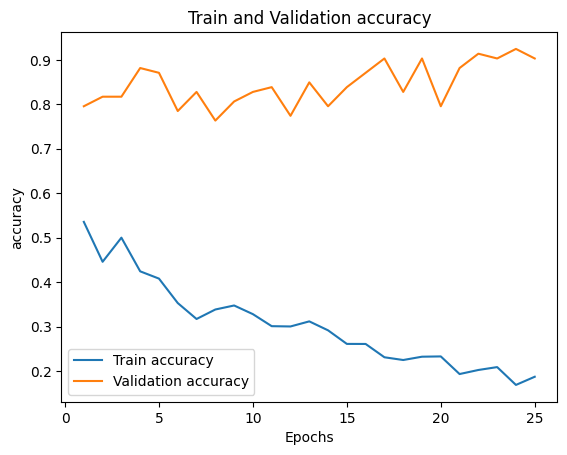

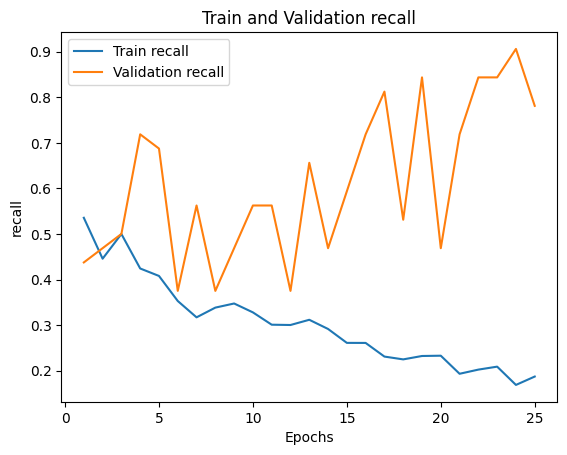

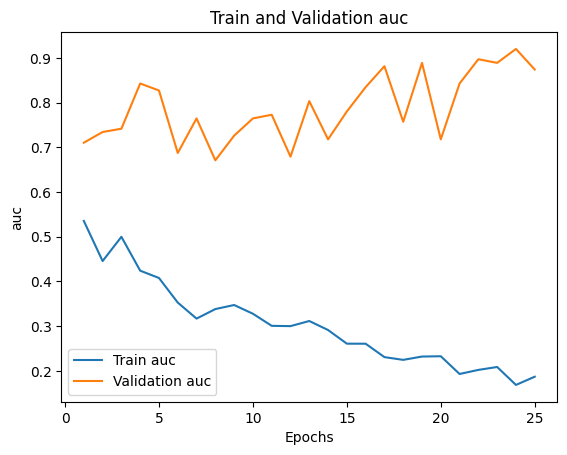

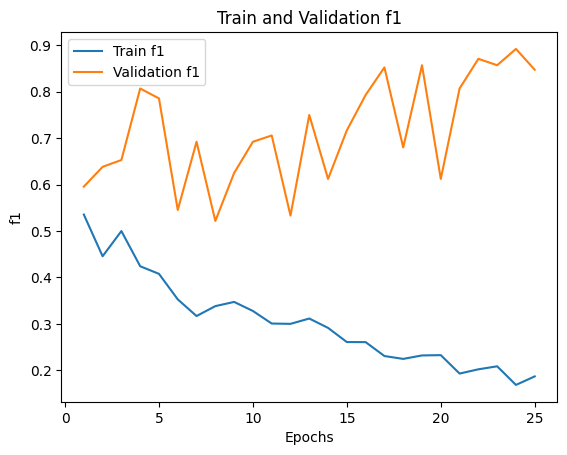

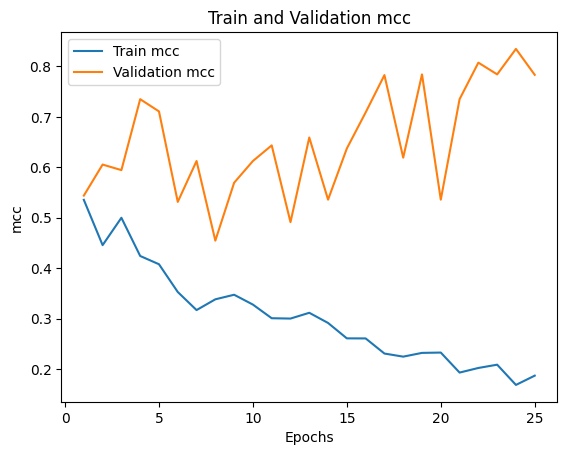

In [ ]:
import logging
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import monai
from monai.data import ImageDataset, DataLoader
from monai.transforms import EnsureChannelFirst, Compose, RandRotate90, Resize, ScaleIntensity, RepeatChannel
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, roc_curve, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.models.video import r3d_18

def load_image_paths_and_labels(cancer_dir, normal_dir):
    """
    Load image paths and corresponding labels from the cancer and normal directories.

    Args:
    - cancer_dir (str): Directory containing the cancer image files.
    - normal_dir (str): Directory containing the normal image files.

    Returns:
    - image_paths (List[str]): List of image file paths.
    - labels (List[int]): List of labels corresponding to the image file paths.
    """
    image_paths = []
    labels = []

    # Load cancer images
    for file in os.listdir(cancer_dir):
        if file.endswith('.nii.gz'):
            image_paths.append(os.path.join(cancer_dir, file))
            labels.append(1)  # Cancer label

    # Load normal images
    for file in os.listdir(normal_dir):
        if file.endswith('.nii.gz'):
            image_paths.append(os.path.join(normal_dir, file))
            labels.append(0)  # Normal label

    return image_paths, labels

def plot_and_save_metrics(epochs, train_metrics, val_metrics, metric_name, save_path):
    plt.figure()
    plt.plot(epochs, train_metrics, label=f'Train {metric_name}')
    plt.plot(epochs, val_metrics, label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'Train and Validation {metric_name}')
    plt.savefig(os.path.join(save_path, f'{metric_name}.png'))

class ResNeXt3D(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNeXt3D, self).__init__()
        self.model = r3d_18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

def main():
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    # Define data paths
    cancer_dir = '/content/drive/MyDrive/Praktikum/common_datasets/common_30P/'  # Directory containing the cancer image files
    normal_dir = '/content/drive/MyDrive/Praktikum/common_datasets/common_30P_normal/'  # Directory containing the normal image files

    # Number of epochs
    num_epochs = 50  # Change this value to set the number of epochs

    # Load image paths and labels
    images, labels = load_image_paths_and_labels(cancer_dir, normal_dir)
    labels = np.array(labels, dtype=np.int64)

    # Debugging: Print number of images and labels
    print(f"Number of images: {len(images)}, Number of labels: {len(labels)}")
    print(f"Labels distribution: {np.bincount(labels)}")

    # Define transforms
    train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), RepeatChannel(repeats=3), Resize((96, 96, 96)), RandRotate90()])
    val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), RepeatChannel(repeats=3), Resize((96, 96, 96))])

    # Split dataset into training and validation sets
    train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Debugging: Print train and validation label distributions
    print(f"Train labels distribution: {np.bincount(train_labels)}")
    print(f"Validation labels distribution: {np.bincount(val_labels)}")

    # Create datasets and dataloaders
    train_ds = ImageDataset(image_files=train_images, labels=train_labels, transform=train_transforms)
    val_ds = ImageDataset(image_files=val_images, labels=val_labels, transform=val_transforms)

    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())

    # Create ResNeXt50 3D, CrossEntropyLoss and Adam optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ResNeXt3D(num_classes=2).to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 1e-5)

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    epoch_accuracy_values = list()
    epoch_recall_values = list()
    epoch_auc_values = list()
    epoch_f1_values = list()
    epoch_mcc_values = list()
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{num_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_ds) // train_loader.batch_size
            print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
            writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_preds = []
            val_true = []
            with torch.no_grad():
                num_correct = 0.0
                metric_count = 0
                for val_data in val_loader:
                    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                    val_outputs = model(val_images)
                    val_preds.extend(val_outputs.argmax(dim=1).cpu().numpy())
                    val_true.extend(val_labels.cpu().numpy())
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                    metric_count += len(value)
                    num_correct += value.sum().item()
            accuracy = accuracy_score(val_true, val_preds)
            recall = recall_score(val_true, val_preds)
            auc = roc_auc_score(val_true, val_preds)
            f1 = f1_score(val_true, val_preds)
            mcc = matthews_corrcoef(val_true, val_preds)

            epoch_accuracy_values.append(accuracy)
            epoch_recall_values.append(recall)
            epoch_auc_values.append(auc)
            epoch_f1_values.append(f1)
            epoch_mcc_values.append(mcc)

            if accuracy > best_metric:
                best_metric = accuracy
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model_classification3d_5E_RNext50_3D_512_20P.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current accuracy: {accuracy:.4f} best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", accuracy, epoch + 1)

    # Save metrics as PNG
    epochs = list(range(1, num_epochs + 1))
    metrics = {
        'accuracy': epoch_accuracy_values,
        'recall': epoch_recall_values,
        'auc': epoch_auc_values,
        'f1': epoch_f1_values,
        'mcc': epoch_mcc_values
    }
    for metric_name, metric_values in metrics.items():
        plot_and_save_metrics(epochs[:len(metric_values)], epoch_loss_values[:len(metric_values)], metric_values, metric_name, '/content/')

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()

if __name__ == "__main__":
    main()
